In [14]:
import glob
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import *

# Utility Functions

In [15]:
def sclean(s):
    """
    Maccor has a custom time format. This function converts the Maccor time
    string to minutes.
    :param s: A Maccor string containing the running time of this step.
    :returns: time in minutes.
    :raises none: no exception raised
    """
    parts = s.split("d ")
    day  = int(parts[0])
    time = parts[1]
    z=sum(x * float(t) for x, t in zip([1/60, 1, 60], reversed(time.split(":"))))+day*1440
    return z

# I am trying to follow the style guide of Matt Harrison. He loves to use 
# chaining for doing routine dataframe cleanup.

def tweak(df,x):
    """
    Creates a new column with the step time in minutes and drops the original
    Maccor format StepTime column.
    :param u: A string containing the UUT designator
    :param t: A string containing the specific test for that UUT
    :returns: cleaned data frame
    :raises none: no exception raised
    """
    trans={"U01":"Vendor","U02":"FW1.6.0-1","U03":"FW1.6.0-2","U04":"FW1.6.1-1","U05":"FW1.6.1-2",\
           "U06":"FW1.6.1-1 (48 hour)","U07":"FW1.6.1-2 (48 hour)"}
    uut = "U"+re.search('_U(.+?)_', x)[1]
    t = trans[uut]
    return (df
           .assign(Stime = lambda df_:df_['StepTime'].map(sclean), UUT=uut, Test= t)
           .drop('StepTime', axis=1)
           )

colors = {'U01':'red', 'U02':'green', 'U03':'springgreen', 'U04':'indigo','U05':'plum'}

from functools import *
pcsv = partial(pd.read_csv,skiprows=4,sep="\t", header=0, usecols=[0,1,2,4,5,7,8,9],index_col=0)

# Import Data

In [16]:
l = pd.concat([tweak(pcsv(x),x) for x in glob.glob("Data/*.txt")])
l.query("State=='D'",inplace=True)
l.query('UUT != "U06" and UUT != "U07"',inplace=True)

## Normalize Capacity Data

In [17]:
dis = (l
       .groupby(['UUT'])
       .agg({"Amp-hr":"max"})
       )
z=dict(dis.reset_index().values)
df = (l
            .groupby(['UUT','Cyc#'])
            .agg({"Amp-hr":"max"})
            .reset_index()
            .assign(Ah  = lambda df_:df_['Amp-hr']/df_['UUT'].map(z))
            .drop("Amp-hr",axis=1)
            .query("Ah>0.84")
      )

## Plot Data

Text(20, 20, 'Vendor Charge 2x\nLonger Than Turbo')

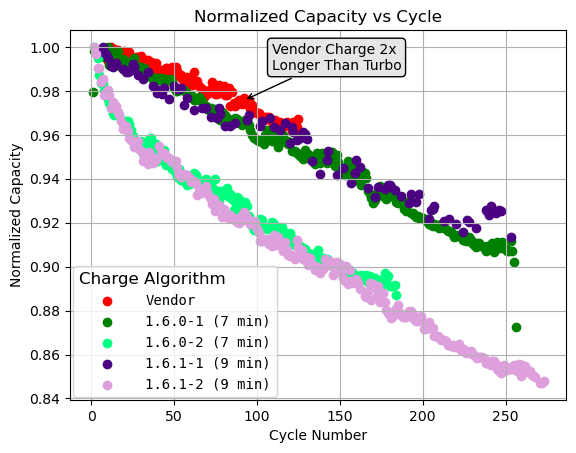

In [18]:
# Some name translations
trans={"U01":"Vendor","U02":"1.6.0-1 (7 min)" ,"U03":"1.6.0-2 (7 min)","U04":"1.6.1-1 (9 min)","U05":"1.6.1-2 (9 min)",\
       "U06":"1.6.1-1 (48 hour)","U07":"1.6.1-2 (48 hour)"}
colors = {'U01':'red', 'U02':'green', 'U03':'springgreen', 'U04':'indigo','U05':'plum'}

# Generate Plot
fig,ax = plt.subplots()
for name in ['U01','U02','U03','U04','U05']:
    ax.scatter(df[df.UUT==name]['Cyc#'],df[df.UUT==name].Ah,label=trans[name],c=colors[name])

ax.set_xlabel("Cycle Number")
ax.set_ylabel("Normalized Capacity")
ax.set_title("Normalized Capacity vs Cycle")
ax.grid()
leg=plt.legend(fontsize = '8', title = 'Charge Algorithm', title_fontsize = '12', \
           bbox_to_anchor=(0.33, 0.18, 0.1, 0.2), prop={'family': 'monospace'}, handlelength=4)
leg._legend_box.align = "left"
# Add annotation with arrow
bbox_args = dict(boxstyle="round", fc="0.9")
arrow_args = dict(arrowstyle="->")
ax.annotate('Vendor Charge 2x\nLonger Than Turbo', xy=(0.35, 0.81), xycoords='axes fraction',
             xytext=(20, 20), textcoords='offset points',
             ha="left", va="bottom",
             bbox=bbox_args,            
             arrowprops=arrow_args)